# CAGE on Spouse data

Code adapted from: [https://github.com/oishik75/CAGE/blob/master/sms_mixed.py](https://github.com/oishik75/CAGE/blob/master/sms_mixed.py)

## Preamble

In [1]:
# Importations.
import numpy as np
import pandas as pd
import torch
from torch import optim
from cage_discrete import *

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define functions

In [2]:
def convert_L(L):
    '''
    Take LF matrix with class assignments in {-1,1} and absention = 0,
    and swap values such that class assignments are in {0,1} and absention = -1.
    '''
    L_new = np.where(L == -1, 5, L)
    L_new = np.where(L_new == 0, -1, L_new)
    L_new = np.where(L_new == 5, 0, L_new)
    return L_new
    
def convert_y(y):
    '''
    Take true labels with class assignments in {-1,1}
    and swap values such that class assignments are in {0,1}.
    '''
    y_new = np.where(y == -1, 0, y)
    return y_new


def score(y_true, y_pred, verbose = True, plot_confusion = True, abstain = -1):
        
    '''
    Compute performance metrics.
    '''
        
    # Filter out abstained predictions.
    initial_size = y_pred.shape[0]
    filter_abstain = np.where(y_pred == abstain, False, True)
    y_true = y_true.reshape(y_pred.shape)
    y_pred = y_pred[filter_abstain]
    y_true = y_true[filter_abstain]
        
    # Compute performance metrics.
    confusion = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division = 0)
    precision = precision_score(y_true, y_pred, zero_division = 0)
    recall = recall_score(y_true, y_pred, zero_division = 0)
    roc = 0.
    try:
        roc = roc_auc_score(y_true, y_pred)
    except ValueError:
        print("Could not compute ROC AUC.")
    coverage = y_pred.shape[0] / initial_size
        

    if verbose:
        print("\n---------------------------------------------")
        print("tn, fp, fn, tp =", confusion.ravel())
        print("F1             =", f1)
        print("Accuracy       =", acc)
        print("Precision      =", precision)
        print("Recall         =", recall)
        print("ROC AUC        =", roc)
        print("Coverage       =", coverage)
        print("---------------------------------------------\n")
        
    # Plot confusion matrix as heatmap, if specified.
    if plot_confusion and (len(confusion) > 0):
        plt.rcParams["figure.figsize"] = (5, 4)
        ax = plt.subplot()
        # (annot = True) to annotate cells.
        # (ftm = "g") to disable scientific notation.
        sns.heatmap(confusion, annot = True, fmt = "g", ax = ax);  
        # Labels, title, and ticks.
        ax.set_xlabel("\nPredicted labels");
        ax.set_ylabel("True labels\n"); 
        ax.set_title("Confusion Matrix\n"); 
        ax.xaxis.set_ticklabels(["-1 (negative)", "1 (positive)"]); 
        ax.yaxis.set_ticklabels(["-1 (negative)", "1 (positive)"]);
        plt.show()

    return [acc, f1, precision, recall, roc, coverage]

## Read data

In [3]:
# Read in labeling function matrix files.
df_train = pd.read_csv("../../data/Spouse/spouse_lf_matrix_train.csv")
df_val = pd.read_csv("../../data/Spouse/spouse_lf_matrix_val.csv")
df_test = pd.read_csv("../../data/Spouse/spouse_lf_matrix_test.csv")

# Explore.
print("\n---------------------------")
print("TRAINING DATA:")
print("---------------------------\n")
print(df_train.info())
display(df_train)

print("---------------------------")
print("VALIDATION DATA:")
print("---------------------------\n")
print(df_val.info())
display(df_val)

print("---------------------------")
print("TEST DATA:")
print("---------------------------\n")
print(df_test.info())
display(df_test)


---------------------------
TRAINING DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        3858 non-null   int64
 1   1        3858 non-null   int64
 2   2        3858 non-null   int64
 3   3        3858 non-null   int64
 4   Label    3858 non-null   int64
 5   Snorkel  3858 non-null   int64
dtypes: int64(6)
memory usage: 181.0 KB
None


,0,1,2,3,Label,Snorkel
0,0,0,0,0,-1,0
1,0,0,0,0,-1,0
2,0,0,-1,0,-1,-1
3,0,0,0,0,-1,0
4,0,0,0,0,-1,0
...,...,...,...,...,...,...
3853,0,0,-1,0,-1,-1
3854,0,0,0,0,-1,0
3855,0,0,0,0,-1,0
3856,0,0,0,0,-1,0


---------------------------
VALIDATION DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        553 non-null    int64
 1   1        553 non-null    int64
 2   2        553 non-null    int64
 3   3        553 non-null    int64
 4   Label    553 non-null    int64
 5   Snorkel  553 non-null    int64
dtypes: int64(6)
memory usage: 26.0 KB
None


,0,1,2,3,Label,Snorkel
0,0,0,0,0,-1,0
1,0,0,0,0,-1,0
2,0,0,0,0,-1,0
3,0,0,0,0,-1,0
4,0,0,0,0,-1,0
...,...,...,...,...,...,...
548,0,0,0,0,-1,0
549,1,1,0,0,-1,1
550,0,0,0,0,-1,0
551,0,0,0,0,-1,0


---------------------------
TEST DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        1101 non-null   int64
 1   1        1101 non-null   int64
 2   2        1101 non-null   int64
 3   3        1101 non-null   int64
 4   Label    1101 non-null   int64
 5   Snorkel  1101 non-null   int64
dtypes: int64(6)
memory usage: 51.7 KB
None


,0,1,2,3,Label,Snorkel
0,0,0,0,0,1,0
1,0,0,0,0,-1,0
2,0,0,-1,-1,-1,-1
3,0,0,0,0,-1,0
4,0,0,0,0,-1,0
...,...,...,...,...,...,...
1096,0,0,0,0,-1,0
1097,0,0,0,0,-1,0
1098,0,0,0,0,-1,0
1099,0,0,0,0,-1,0


In [4]:
# Spam dataset: Disaggregate labeling function outputs and gold labels.
# Drop third and final LF.
L_train = np.array(df_train.drop(columns = ["Label", "Snorkel"]))
y_train = np.array(df_train["Label"])

L_val = np.array(df_val.drop(columns = ["Label", "Snorkel"]))
y_val = np.array(df_val["Label"])

L_test = np.array(df_test.drop(columns = ["Label", "Snorkel"]))
y_test = np.array(df_test["Label"])

print("\n***L_train.shape =", L_train.shape)
display(L_train)
print("\n***L_val.shape =", L_val.shape)
display(L_val)
print("\n***L_test.shape =", L_test.shape)
display(L_test)

display(y_train)
display(y_val)
display(y_test)


***L_train.shape = (3858, 4)


array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0, -1,  0],
       ...,
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])


***L_val.shape = (553, 4)


array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])


***L_test.shape = (1101, 4)


array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0, -1, -1],
       ...,
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])

array([-1, -1, -1, ..., -1, -1, -1])

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

array([ 1, -1, -1, ..., -1, -1, -1])

## Process data

In [5]:
print(np.unique(L_train, return_counts = True))
print(np.unique(L_val, return_counts = True))
print(np.unique(L_test, return_counts = True))

print(np.unique(y_train, return_counts = True))
print(np.unique(y_val, return_counts = True))
print(np.unique(y_test, return_counts = True))

(array([-1,  0,  1]), array([  585, 14317,   530]))
(array([-1,  0,  1]), array([  87, 2068,   57]))
(array([-1,  0,  1]), array([ 152, 4112,  140]))
(array([-1,  1]), array([3572,  286]))
(array([-1,  1]), array([512,  41]))
(array([-1,  1]), array([1020,   81]))


In [6]:
# Take LF matrix with class assignments in {-1,1} and absention = 0,
# and swap values such that class assignments are in {0,1} and absention = -1.
L_train = convert_L(L_train)
L_val = convert_L(L_val)
L_test = convert_L(L_test)

y_train = convert_y(y_train)
y_val = convert_y(y_val)
y_test = convert_y(y_test)

In [7]:
print(np.unique(L_train, return_counts = True))
print(np.unique(L_val, return_counts = True))
print(np.unique(L_test, return_counts = True))

print(np.unique(y_train, return_counts = True))
print(np.unique(y_val, return_counts = True))
print(np.unique(y_test, return_counts = True))

(array([-1,  0,  1]), array([14317,   585,   530]))
(array([-1,  0,  1]), array([2068,   87,   57]))
(array([-1,  0,  1]), array([4112,  152,  140]))
(array([0, 1]), array([3572,  286]))
(array([0, 1]), array([512,  41]))
(array([0, 1]), array([1020,   81]))


In [8]:
L_train

array([[-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1,  0, -1],
       ...,
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1]])

In [9]:
# Convert to tensor.
L_train = torch.tensor(L_train)
L_val = torch.tensor(L_val)
L_test = torch.tensor(L_test)

y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

In [10]:
# Labeling Function Classes
k = torch.tensor([1, 1, 0, 0]).long()

print(k.shape)
display(k)

n_classes = 2
n_lfs = 4

torch.Size([4])


tensor([1, 1, 0, 0])

## Define quality guides

In [11]:
# CAGE method: Quality Guides all set to 0.9.
a = torch.ones(n_lfs).double() * 0.9  

In [12]:
# Majority vote heuristic.
mv_priors = [0.9772727272727273, 0.9913793103448276, 
             0.9894736842105263, 0.986013986013986]
mv_priors = torch.tensor(mv_priors).double()

In [13]:
# True accuracies.
empirical_accuracies = [0.399015, 0.467742, 0.967963, 0.939189]
empirical_accuracies = torch.tensor(empirical_accuracies).double()

In [14]:
# Assuming uniformly low accuracy.
low = [0.4] * n_lfs
low = torch.tensor(low).double()
print(low)

tensor([0.4000, 0.4000, 0.4000, 0.4000], dtype=torch.float64)


In [15]:
# Random priors.
random = np.random.rand(n_lfs)
random = torch.tensor(random).double()
print(random)

tensor([0.1263, 0.2793, 0.8952, 0.7720], dtype=torch.float64)


## Train / test with select guide values


------------ CAGE GUIDES ------------
tensor([0.9000, 0.9000, 0.9000, 0.9000], dtype=torch.float64)
---------------------------------------------------

Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.13804713804713806
Epoch: 3	f1_score: 0.13804713804713806
Epoch: 4	f1_score: 0.13804713804713806
Epoch: 5	f1_score: 0.08695652173913043
Epoch: 6	f1_score: 0.08695652173913043
Epoch: 7	f1_score: 0.08695652173913043
Epoch: 8	f1_score: 0.13804713804713806
Epoch: 9	f1_score: 0.13804713804713806
Epoch: 10	f1_score: 0.08695652173913043
Epoch: 11	f1_score: 0.08695652173913043
Epoch: 12	f1_score: 0.08695652173913043
Epoch: 13	f1_score: 0.08695652173913043
Epoch: 14	f1_score: 0.08695652173913043
Epoch: 15	f1_score: 0.08695652173913043
Epoch: 16	f1_score: 0.08695652173913043
Epoch: 17	f1_score: 0.08695652173913043
Epoch: 18	f1_score: 0.08695652173913043
Epoch: 19	f1_score: 0.08695652173913043
Epoch: 20	f1_score: 0.08695652173913043
Epoch: 21	f1_score: 0.08695652173913043
Epoch: 2

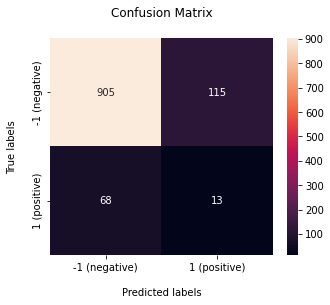


------------ LOW ACCURACY ------------
tensor([0.4000, 0.4000, 0.4000, 0.4000], dtype=torch.float64)
---------------------------------------------------

Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.14113597246127366
Epoch: 3	f1_score: 0.14113597246127366
Epoch: 4	f1_score: 0.14068441064638781
Epoch: 5	f1_score: 0.14068441064638781
Epoch: 6	f1_score: 0.14068441064638781
Epoch: 7	f1_score: 0.14068441064638781
Epoch: 8	f1_score: 0.14068441064638781
Epoch: 9	f1_score: 0.14068441064638781
Epoch: 10	f1_score: 0.14068441064638781
Epoch: 11	f1_score: 0.14068441064638781
Epoch: 12	f1_score: 0.14068441064638781
Epoch: 13	f1_score: 0.14068441064638781
Epoch: 14	f1_score: 0.14068441064638781
Epoch: 15	f1_score: 0.14068441064638781
Epoch: 16	f1_score: 0.14068441064638781
Epoch: 17	f1_score: 0.14068441064638781
Epoch: 18	f1_score: 0.14068441064638781
Epoch: 19	f1_score: 0.14068441064638781
Epoch: 20	f1_score: 0.14068441064638781
Epoch: 21	f1_score: 0.14068441064638781
Epoch: 

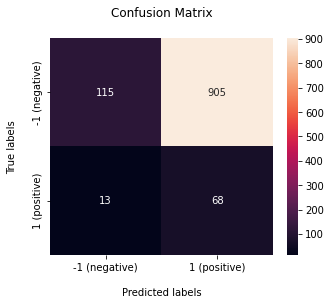


------------ RANDOM PRIORS ------------
tensor([0.1263, 0.2793, 0.8952, 0.7720], dtype=torch.float64)
---------------------------------------------------

Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_s

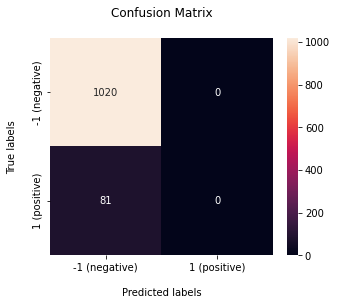


------------ MAJORITY VOTE HEURISTIC ------------
tensor([0.9773, 0.9914, 0.9895, 0.9860], dtype=torch.float64)
---------------------------------------------------

Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.08695652173913043
Epoch: 3	f1_score: 0.13804713804713806
Epoch: 4	f1_score: 0.13804713804713806
Epoch: 5	f1_score: 0.13804713804713806
Epoch: 6	f1_score: 0.08695652173913043
Epoch: 7	f1_score: 0.08695652173913043
Epoch: 8	f1_score: 0.08695652173913043
Epoch: 9	f1_score: 0.08695652173913043
Epoch: 10	f1_score: 0.08695652173913043
Epoch: 11	f1_score: 0.13804713804713806
Epoch: 12	f1_score: 0.13804713804713806
Epoch: 13	f1_score: 0.13804713804713806
Epoch: 14	f1_score: 0.08695652173913043
Epoch: 15	f1_score: 0.08695652173913043
Epoch: 16	f1_score: 0.08695652173913043
Epoch: 17	f1_score: 0.08695652173913043
Epoch: 18	f1_score: 0.08695652173913043
Epoch: 19	f1_score: 0.08695652173913043
Epoch: 20	f1_score: 0.08695652173913043
Epoch: 21	f1_score: 0.08695652173913

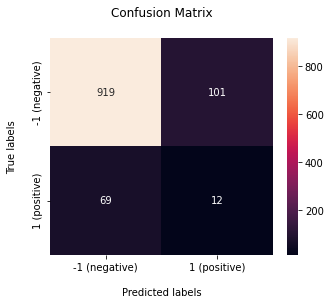


------------ EMPIRICAL ACCURACIES ------------
tensor([0.3990, 0.4677, 0.9680, 0.9392], dtype=torch.float64)
---------------------------------------------------

Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 

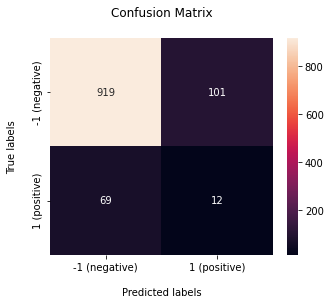

In [16]:
# Learn accuracies.
priors = [a, low, random, mv_priors, empirical_accuracies]
prior_names = ["CAGE GUIDES", "LOW ACCURACY", "RANDOM PRIORS", "MAJORITY VOTE HEURISTIC", "EMPIRICAL ACCURACIES"]
epochs = 100
lr = 0.1
for i in range(len(priors)):
    
    print("\n------------ {} ------------".format(prior_names[i]))
    print(priors[i])
    print("---------------------------------------------------\n")
        
    # Initialize parameters
    theta = torch.ones((n_classes, n_lfs)).double() * 1
    theta.requires_grad = True

    optimizer = optim.Adam([theta], lr = lr, weight_decay = 0)
    
    # Train.
    # Training loop adapted from: https://github.com/oishik75/CAGE/blob/master/sms_mixed.py
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = log_likelihood_loss_discrete(theta, L_train, k, n_classes)
        prec_loss = precision_loss(theta, k, n_classes, priors[i])
        loss += prec_loss
        y_pred = np.argmax(probability_l_y(theta, L_val, k, n_classes).detach().numpy(), 1)
        print("Epoch: {}\tf1_score: {}".format(epoch, f1_score(y_val, y_pred, average = "binary")))

        loss.backward()
        optimizer.step()

    # Evaluate test scores.
    y_pred_test = np.argmax(probability_l_y(theta, L_test, k, n_classes).detach().numpy(), 1)
    score(y_test, y_pred_test, verbose = True, plot_confusion = True)

## Tune

In [17]:
# Define search space.
guides = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
learning_rates = [0.01, 0.001]
init_theta = [0.8, 0.9, 1.0]

# Take cartesian product to obtain grid search space.
search_space = list(itertools.product(guides, learning_rates, init_theta))
print("\n--- HYPERPARAMETER SEARCH SPACE: ---\n")
print("Total combinations:", len(search_space))
print()
print(search_space)


--- HYPERPARAMETER SEARCH SPACE: ---

Total combinations: 36

[(0.4, 0.01, 0.8), (0.4, 0.01, 0.9), (0.4, 0.01, 1.0), (0.4, 0.001, 0.8), (0.4, 0.001, 0.9), (0.4, 0.001, 1.0), (0.5, 0.01, 0.8), (0.5, 0.01, 0.9), (0.5, 0.01, 1.0), (0.5, 0.001, 0.8), (0.5, 0.001, 0.9), (0.5, 0.001, 1.0), (0.6, 0.01, 0.8), (0.6, 0.01, 0.9), (0.6, 0.01, 1.0), (0.6, 0.001, 0.8), (0.6, 0.001, 0.9), (0.6, 0.001, 1.0), (0.7, 0.01, 0.8), (0.7, 0.01, 0.9), (0.7, 0.01, 1.0), (0.7, 0.001, 0.8), (0.7, 0.001, 0.9), (0.7, 0.001, 1.0), (0.8, 0.01, 0.8), (0.8, 0.01, 0.9), (0.8, 0.01, 1.0), (0.8, 0.001, 0.8), (0.8, 0.001, 0.9), (0.8, 0.001, 1.0), (0.9, 0.01, 0.8), (0.9, 0.01, 0.9), (0.9, 0.01, 1.0), (0.9, 0.001, 0.8), (0.9, 0.001, 0.9), (0.9, 0.001, 1.0)]



--- Guide: 0.4 | LR: 0.01 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.14113597246127366
Epoch: 3	f1_score: 0.14113597246127366
Epoch: 4	f1_score: 0.14113597246127366
Epoch: 5	f1_score: 0.14113597246127366
Epoch: 6	f1_score: 0.14113597246127366
Epoch: 7	f1_score: 0.14113597246127366
Epoch: 8	f1_score: 0.14113597246127366
Epoch: 9	f1_score: 0.14113597246127366
Epoch: 10	f1_score: 0.14113597246127366
Epoch: 11	f1_score: 0.14113597246127366
Epoch: 12	f1_score: 0.14113597246127366
Epoch: 13	f1_score: 0.14113597246127366
Epoch: 14	f1_score: 0.14113597246127366
Epoch: 15	f1_score: 0.14113597246127366
Epoch: 16	f1_score: 0.14113597246127366
Epoch: 17	f1_score: 0.14113597246127366
Epoch: 18	f1_score: 0.14113597246127366
Epoch: 19	f1_score: 0.14068441064638781
Epoch: 20	f1_score: 0.14068441064638781
Epoch: 21	f1_score: 0.14068441064638781
Epoch: 22	f1_score: 0.14068441064638781
Epoch: 23	f1_score: 0.14068441064638781
Epoch: 24	f1_score: 0.14068441064

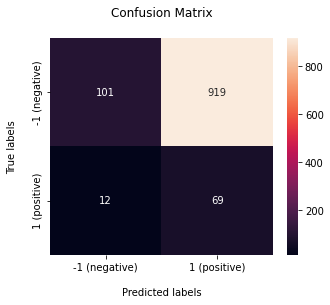


--- Guide: 0.4 | LR: 0.01 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.14113597246127366
Epoch: 3	f1_score: 0.14113597246127366
Epoch: 4	f1_score: 0.14113597246127366
Epoch: 5	f1_score: 0.14113597246127366
Epoch: 6	f1_score: 0.14113597246127366
Epoch: 7	f1_score: 0.14113597246127366
Epoch: 8	f1_score: 0.14113597246127366
Epoch: 9	f1_score: 0.14113597246127366
Epoch: 10	f1_score: 0.14113597246127366
Epoch: 11	f1_score: 0.14113597246127366
Epoch: 12	f1_score: 0.14113597246127366
Epoch: 13	f1_score: 0.14113597246127366
Epoch: 14	f1_score: 0.14113597246127366
Epoch: 15	f1_score: 0.14113597246127366
Epoch: 16	f1_score: 0.14113597246127366
Epoch: 17	f1_score: 0.14113597246127366
Epoch: 18	f1_score: 0.14068441064638781
Epoch: 19	f1_score: 0.14068441064638781
Epoch: 20	f1_score: 0.14068441064638781
Epoch: 21	f1_score: 0.14068441064638781
Epoch: 22	f1_score: 0.14068441064638781
Epoch: 23	f1_score: 0.14068441064638781
Epoch: 24	f1_score: 0.14068441064

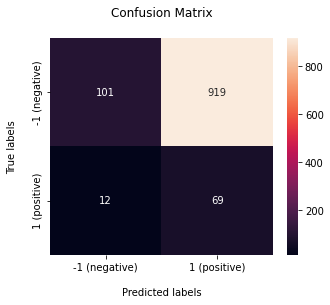


--- Guide: 0.4 | LR: 0.01 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.14113597246127366
Epoch: 3	f1_score: 0.14113597246127366
Epoch: 4	f1_score: 0.14113597246127366
Epoch: 5	f1_score: 0.14113597246127366
Epoch: 6	f1_score: 0.14113597246127366
Epoch: 7	f1_score: 0.14113597246127366
Epoch: 8	f1_score: 0.14113597246127366
Epoch: 9	f1_score: 0.14113597246127366
Epoch: 10	f1_score: 0.14113597246127366
Epoch: 11	f1_score: 0.14113597246127366
Epoch: 12	f1_score: 0.14113597246127366
Epoch: 13	f1_score: 0.14113597246127366
Epoch: 14	f1_score: 0.14113597246127366
Epoch: 15	f1_score: 0.14113597246127366
Epoch: 16	f1_score: 0.14068441064638781
Epoch: 17	f1_score: 0.14068441064638781
Epoch: 18	f1_score: 0.14068441064638781
Epoch: 19	f1_score: 0.14068441064638781
Epoch: 20	f1_score: 0.14068441064638781
Epoch: 21	f1_score: 0.14068441064638781
Epoch: 22	f1_score: 0.14068441064638781
Epoch: 23	f1_score: 0.14068441064638781
Epoch: 24	f1_score: 0.14068441064

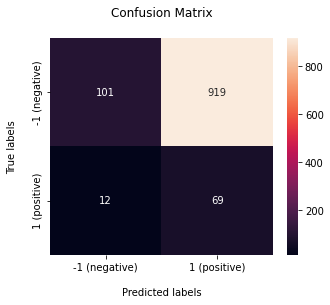


--- Guide: 0.4 | LR: 0.001 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.14068441064638781
Epoch: 5	f1_score: 0.14068441064638781
Epoch: 6	f1_score: 0.14113597246127366
Epoch: 7	f1_score: 0.14113597246127366
Epoch: 8	f1_score: 0.14113597246127366
Epoch: 9	f1_score: 0.14113597246127366
Epoch: 10	f1_score: 0.14113597246127366
Epoch: 11	f1_score: 0.14113597246127366
Epoch: 12	f1_score: 0.14113597246127366
Epoch: 13	f1_score: 0.14113597246127366
Epoch: 14	f1_score: 0.14113597246127366
Epoch: 15	f1_score: 0.14113597246127366
Epoch: 16	f1_score: 0.14113597246127366
Epoch: 17	f1_score: 0.14113597246127366
Epoch: 18	f1_score: 0.14113597246127366
Epoch: 19	f1_score: 0.14113597246127366
Epoch: 20	f1_score: 0.14113597246127366
Epoch: 21	f1_score: 0.14113597246127366
Epoch: 22	f1_score: 0.14113597246127366
Epoch: 23	f1_score: 0.14113597246127366
Epoch: 24	f1_score: 0.14113597246127366
Epoch: 25	f1_score: 0.14

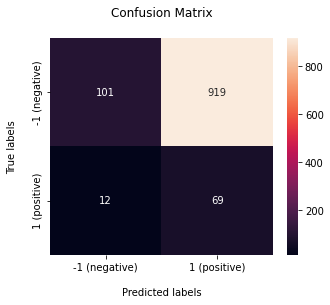


--- Guide: 0.4 | LR: 0.001 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.14068441064638781
Epoch: 4	f1_score: 0.14068441064638781
Epoch: 5	f1_score: 0.14068441064638781
Epoch: 6	f1_score: 0.14113597246127366
Epoch: 7	f1_score: 0.14113597246127366
Epoch: 8	f1_score: 0.14113597246127366
Epoch: 9	f1_score: 0.14113597246127366
Epoch: 10	f1_score: 0.14113597246127366
Epoch: 11	f1_score: 0.14113597246127366
Epoch: 12	f1_score: 0.14113597246127366
Epoch: 13	f1_score: 0.14113597246127366
Epoch: 14	f1_score: 0.14113597246127366
Epoch: 15	f1_score: 0.14113597246127366
Epoch: 16	f1_score: 0.14113597246127366
Epoch: 17	f1_score: 0.14113597246127366
Epoch: 18	f1_score: 0.14113597246127366
Epoch: 19	f1_score: 0.14113597246127366
Epoch: 20	f1_score: 0.14113597246127366
Epoch: 21	f1_score: 0.14113597246127366
Epoch: 22	f1_score: 0.14113597246127366
Epoch: 23	f1_score: 0.14113597246127366
Epoch: 24	f1_score: 0.14113597246127366
Epoch: 2

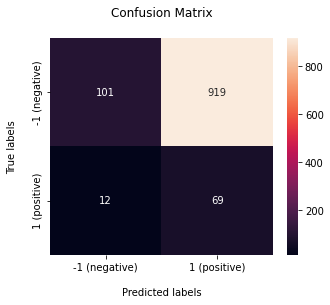


--- Guide: 0.4 | LR: 0.001 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.14068441064638781
Epoch: 4	f1_score: 0.14068441064638781
Epoch: 5	f1_score: 0.14068441064638781
Epoch: 6	f1_score: 0.14113597246127366
Epoch: 7	f1_score: 0.14113597246127366
Epoch: 8	f1_score: 0.14113597246127366
Epoch: 9	f1_score: 0.14113597246127366
Epoch: 10	f1_score: 0.14113597246127366
Epoch: 11	f1_score: 0.14113597246127366
Epoch: 12	f1_score: 0.14113597246127366
Epoch: 13	f1_score: 0.14113597246127366
Epoch: 14	f1_score: 0.14113597246127366
Epoch: 15	f1_score: 0.14113597246127366
Epoch: 16	f1_score: 0.14113597246127366
Epoch: 17	f1_score: 0.14113597246127366
Epoch: 18	f1_score: 0.14113597246127366
Epoch: 19	f1_score: 0.14113597246127366
Epoch: 20	f1_score: 0.14113597246127366
Epoch: 21	f1_score: 0.14113597246127366
Epoch: 22	f1_score: 0.14113597246127366
Epoch: 23	f1_score: 0.14113597246127366
Epoch: 24	f1_score: 0.14113597246127366
Epoch: 2

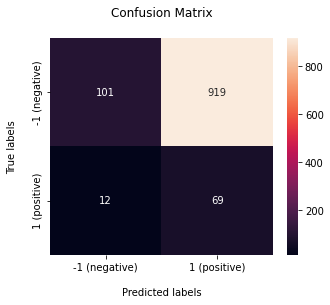


--- Guide: 0.5 | LR: 0.01 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0
E

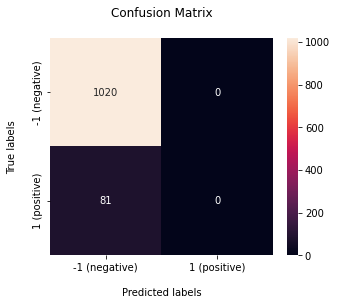


--- Guide: 0.5 | LR: 0.01 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0
E

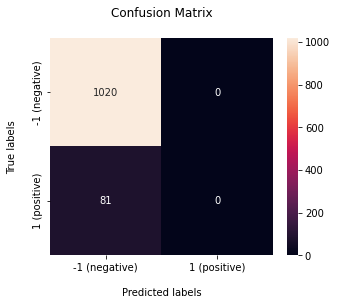


--- Guide: 0.5 | LR: 0.01 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0
E

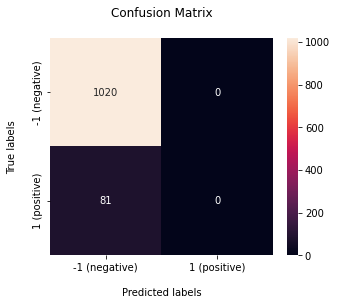


--- Guide: 0.5 | LR: 0.001 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


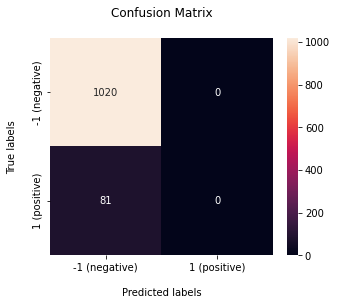


--- Guide: 0.5 | LR: 0.001 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


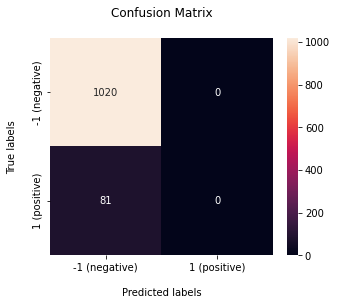


--- Guide: 0.5 | LR: 0.001 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


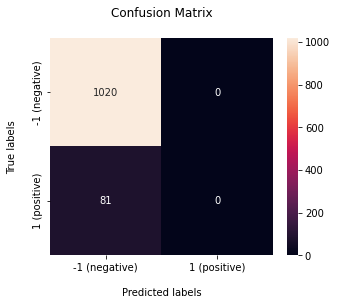


--- Guide: 0.6 | LR: 0.01 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541284404
Epoch: 27	f1_score: 0.07339449541284404
Epoch: 28	f1_score: 0.07339449541284404
Epoch: 29	f1_score: 0.07339449541284404
Epoch: 30	f1_score: 0.07339449541284404
Epoch: 31	f1_score: 0.073

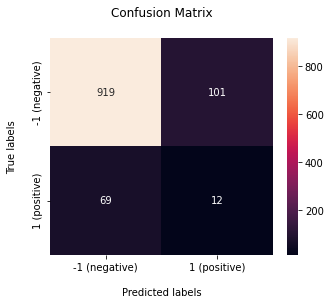


--- Guide: 0.6 | LR: 0.01 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541284404
Epoch: 27	f1_score: 0.07339449541284404
Epoch: 28	f1_score: 0.07339449541284404
Epoch: 29	f1_score: 0.07339449541284404
Epoch: 30	f1_score: 0.07339449541284404
Epoch: 31

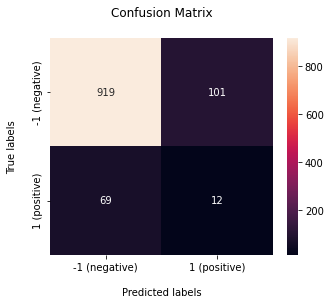


--- Guide: 0.6 | LR: 0.01 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541284404
Epoch: 27	f1_score: 0.07339449541284404
Epoch: 28	f1_score: 0.07339449541284404
Epoch: 29	f1_score: 0.07339449541284404
Epoch: 30	f1_scor

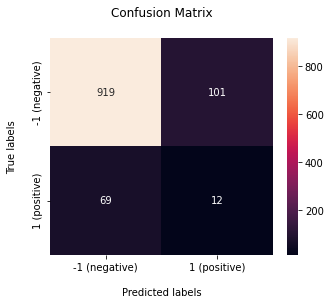


--- Guide: 0.6 | LR: 0.001 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


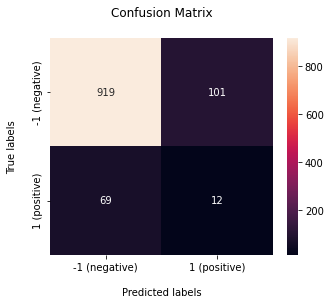


--- Guide: 0.6 | LR: 0.001 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


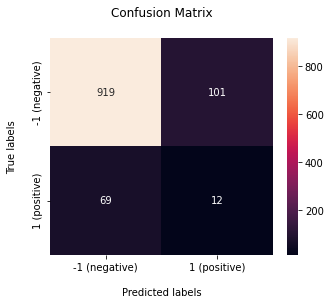


--- Guide: 0.6 | LR: 0.001 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


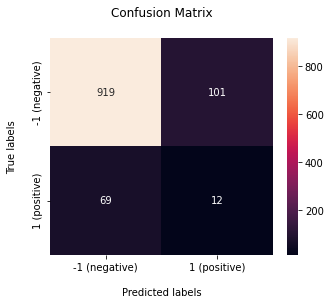


--- Guide: 0.7 | LR: 0.01 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541284404
Epoch: 27	f1_score: 0.07339449541284404
Epoch: 28	f1_score: 0.07339449541284404
Epoch: 29	f1_score: 0.07339449541284404
Epoch: 30	f1_scor

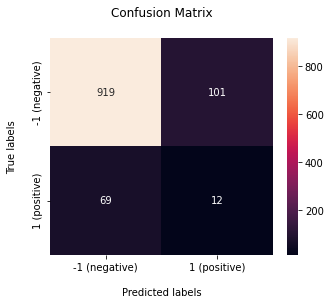


--- Guide: 0.7 | LR: 0.01 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541284404
Epoch: 27	f1_score: 0.07339449541284404
Epoch: 28	f1_score: 0.07339449541284404
Epoch: 29	f1_score: 0.073

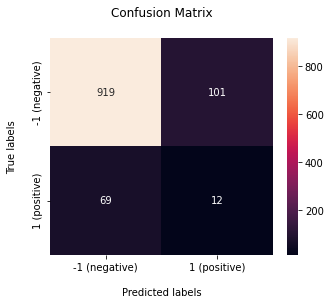


--- Guide: 0.7 | LR: 0.01 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541284404
Epoch: 27	f1_score: 0.07339449541284404
Epoch: 28	f1_score: 0.07339449541284404
Epoch: 29

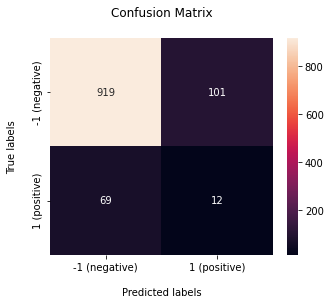


--- Guide: 0.7 | LR: 0.001 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


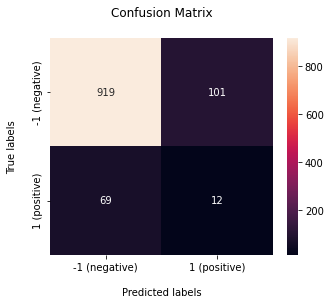


--- Guide: 0.7 | LR: 0.001 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


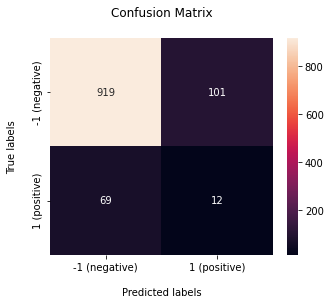


--- Guide: 0.7 | LR: 0.001 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.0
Epoch: 26	f1_score: 0.0
Epoch: 27	f1_score: 0.0
Epoch: 28	f1_score: 0.0
Epoch: 29	f1_score: 0.0
Epoch: 30	f1_score: 0.0
Epoch: 31	f1_score: 0.0
Epoch: 32	f1_score: 0.0
Epoch: 33	f1_score: 0.0
Epoch: 34	f1_score: 0.0
Epoch: 35	f1_score: 0.0
Epoch: 36	f1_score: 0.0
Epoch: 37	f1_score: 0.0
Epoch: 38	f1_score: 0.0
Epoch: 39	f1_score: 0.0


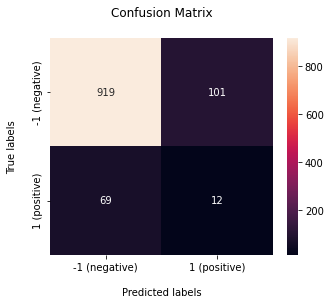


--- Guide: 0.8 | LR: 0.01 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541

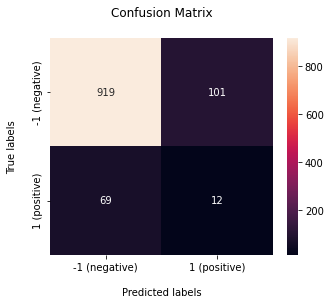


--- Guide: 0.8 | LR: 0.01 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25

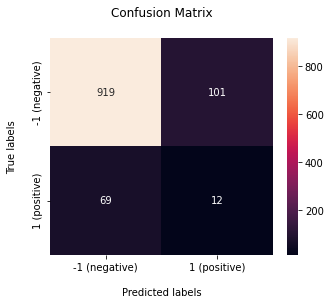


--- Guide: 0.8 | LR: 0.01 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.07339449541284404
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541

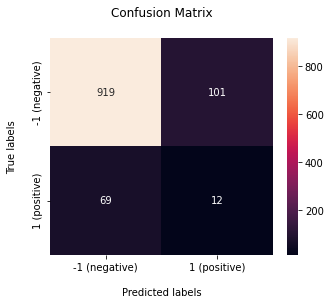


--- Guide: 0.8 | LR: 0.001 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.0
Epoch: 12	f1_score: 0.0
Epoch: 13	f1_score: 0.0
Epoch: 14	f1_score: 0.0
Epoch: 15	f1_score: 0.0
Epoch: 16	f1_score: 0.0
Epoch: 17	f1_score: 0.0
Epoch: 18	f1_score: 0.0
Epoch: 19	f1_score: 0.0
Epoch: 20	f1_score: 0.0
Epoch: 21	f1_score: 0.0
Epoch: 22	f1_score: 0.0
Epoch: 23	f1_score: 0.0
Epoch: 24	f1_score: 0.0
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541284404
Epoch: 27	f1_score: 0.07339449541284404
Epoch: 28	f1_score: 0.07339449541284404
Epoch: 29	f1_score: 0.07339449541284404
Epoch: 30	f1_score: 0.07339449541284404
Epoch: 31	f1_score: 0.07339449541284404
Epoch: 32	f1_score: 0.07339449541284404
Epoch: 33	f1_score: 0.07339449541284404


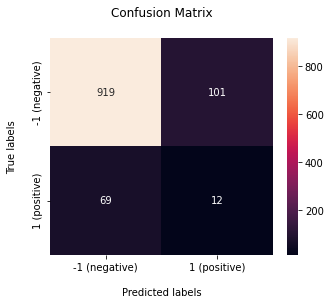


--- Guide: 0.8 | LR: 0.001 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.0
Epoch: 3	f1_score: 0.0
Epoch: 4	f1_score: 0.0
Epoch: 5	f1_score: 0.0
Epoch: 6	f1_score: 0.0
Epoch: 7	f1_score: 0.0
Epoch: 8	f1_score: 0.0
Epoch: 9	f1_score: 0.0
Epoch: 10	f1_score: 0.0
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541284404
Epoch: 25	f1_score: 0.07339449541284404
Epoch: 26	f1_score: 0.07339449541284404
Epoch: 27	f1_score: 0.07339449541284404
Epoch: 28	f1_sco

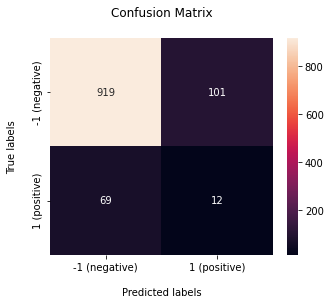


--- Guide: 0.8 | LR: 0.001 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.07339449541284404
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.0733944954

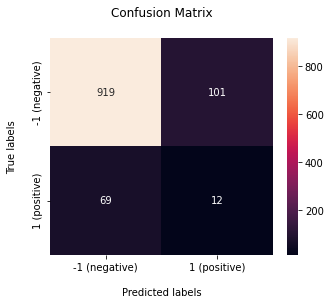


--- Guide: 0.9 | LR: 0.01 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.07339449541284404
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541

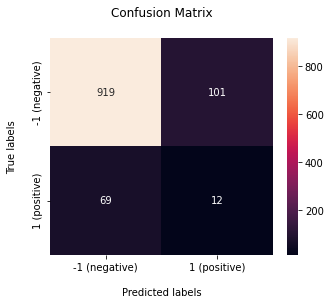


--- Guide: 0.9 | LR: 0.01 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.07339449541284404
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541

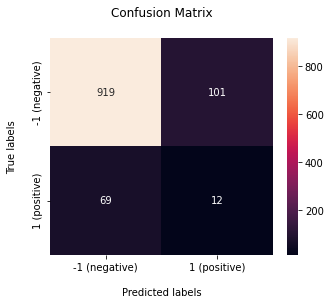


--- Guide: 0.9 | LR: 0.01 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.07339449541284404
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.07339449541

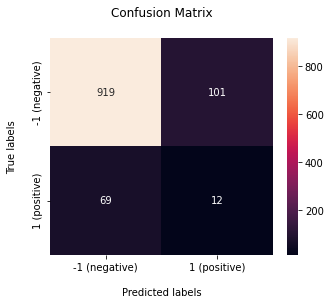


--- Guide: 0.9 | LR: 0.001 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.07339449541284404
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.0733944954

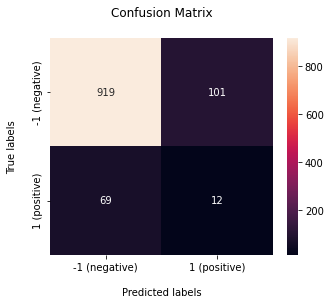


--- Guide: 0.9 | LR: 0.001 | Init theta: 0.9 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.07339449541284404
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.0733944954

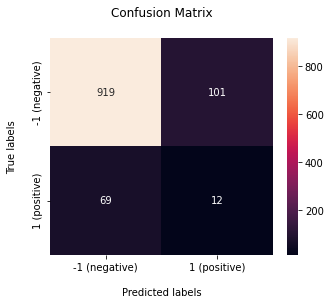


--- Guide: 0.9 | LR: 0.001 | Init theta: 1.0 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.07339449541284404
Epoch: 3	f1_score: 0.07339449541284404
Epoch: 4	f1_score: 0.07339449541284404
Epoch: 5	f1_score: 0.07339449541284404
Epoch: 6	f1_score: 0.07339449541284404
Epoch: 7	f1_score: 0.07339449541284404
Epoch: 8	f1_score: 0.07339449541284404
Epoch: 9	f1_score: 0.07339449541284404
Epoch: 10	f1_score: 0.07339449541284404
Epoch: 11	f1_score: 0.07339449541284404
Epoch: 12	f1_score: 0.07339449541284404
Epoch: 13	f1_score: 0.07339449541284404
Epoch: 14	f1_score: 0.07339449541284404
Epoch: 15	f1_score: 0.07339449541284404
Epoch: 16	f1_score: 0.07339449541284404
Epoch: 17	f1_score: 0.07339449541284404
Epoch: 18	f1_score: 0.07339449541284404
Epoch: 19	f1_score: 0.07339449541284404
Epoch: 20	f1_score: 0.07339449541284404
Epoch: 21	f1_score: 0.07339449541284404
Epoch: 22	f1_score: 0.07339449541284404
Epoch: 23	f1_score: 0.07339449541284404
Epoch: 24	f1_score: 0.0733944954

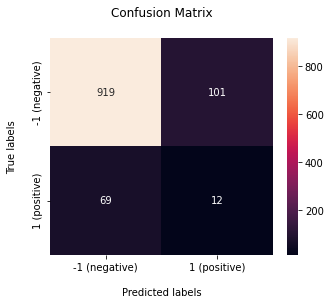


--- HYPERPARAMETER VALUES FOR MAX F1 SCORE: ---

--- Guide: 0.4 | LR: 0.01 | Init theta: 0.8 ---


In [18]:
# Learn accuracies.
epochs = 100
max_f1 = 0
max_hparams = []
for hparams in search_space:
    
    # Extract hyperparameter values.
    guide = hparams[0]
    lr = hparams[1]
    scale_theta = hparams[2]
    print("\n--- Guide: {} | LR: {} | Init theta: {} ---".format(guide, lr, scale_theta))
    
    # Initialize parameters
    theta = torch.ones((n_classes, n_lfs)).double() * scale_theta
    theta.requires_grad = True
    optimizer = optim.Adam([theta], lr = lr, weight_decay = 0)
    
    # Train.
    # Training loop adapted from: https://github.com/oishik75/CAGE/blob/master/sms_mixed.py
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = log_likelihood_loss_discrete(theta, L_train, k, n_classes)
        prec_loss = precision_loss(theta, k, n_classes, torch.tensor([guide] * n_lfs).double())
        loss += prec_loss
        y_pred = np.argmax(probability_l_y(theta, L_val, k, n_classes).detach().numpy(), 1)
        f1 = f1_score(y_val, y_pred, average = "binary")
        print("Epoch: {}\tf1_score: {}".format(epoch, f1))

        loss.backward()
        optimizer.step()

    # Evaluate test scores.
    y_pred_test = np.argmax(probability_l_y(theta, L_test, k, n_classes).detach().numpy(), 1)
    score(y_test, y_pred_test, verbose = True, plot_confusion = True)
    
    # Track max validation F1.
    f1 = f1_score(y_val, y_pred, average = "binary")
    if f1 > max_f1:
        max_f1 = f1
        max_hparams = hparams
    
# View best hyperparameter set.
max_guide = max_hparams[0]
max_lr = max_hparams[1]
max_scale_theta = max_hparams[2]
print("\n--- HYPERPARAMETER VALUES FOR MAX F1 SCORE: ---")
print("\n--- Guide: {} | LR: {} | Init theta: {} ---".format(max_guide, max_lr, max_scale_theta))

## Train / test model with maximum F1


--- HYPERPARAMETER VALUES FOR MAX F1 SCORE: ---

--- Guide: 0.4 | LR: 0.01 | Init theta: 0.8 ---
Epoch: 0	f1_score: 0.0
Epoch: 1	f1_score: 0.0
Epoch: 2	f1_score: 0.14113597246127366
Epoch: 3	f1_score: 0.14113597246127366
Epoch: 4	f1_score: 0.14113597246127366
Epoch: 5	f1_score: 0.14113597246127366
Epoch: 6	f1_score: 0.14113597246127366
Epoch: 7	f1_score: 0.14113597246127366
Epoch: 8	f1_score: 0.14113597246127366
Epoch: 9	f1_score: 0.14113597246127366
Epoch: 10	f1_score: 0.14113597246127366
Epoch: 11	f1_score: 0.14113597246127366
Epoch: 12	f1_score: 0.14113597246127366
Epoch: 13	f1_score: 0.14113597246127366
Epoch: 14	f1_score: 0.14113597246127366
Epoch: 15	f1_score: 0.14113597246127366
Epoch: 16	f1_score: 0.14113597246127366
Epoch: 17	f1_score: 0.14113597246127366
Epoch: 18	f1_score: 0.14113597246127366
Epoch: 19	f1_score: 0.14068441064638781
Epoch: 20	f1_score: 0.14068441064638781
Epoch: 21	f1_score: 0.14068441064638781
Epoch: 22	f1_score: 0.14068441064638781
Epoch: 23	f1_score: 0.14

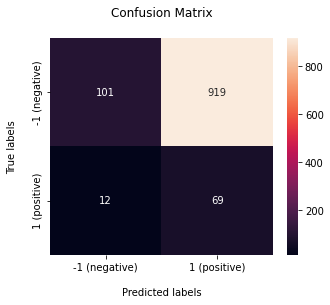

[0.15440508628519528,
 0.12909260991580918,
 0.06983805668016195,
 0.8518518518518519,
 0.47543572984749455,
 1.0]

In [19]:
# View best hyperparameter set.
print("\n--- HYPERPARAMETER VALUES FOR MAX F1 SCORE: ---")
print("\n--- Guide: {} | LR: {} | Init theta: {} ---".format(max_guide, max_lr, max_scale_theta))

# Initialize parameters
theta = torch.ones((n_classes, n_lfs)).double() * max_scale_theta
theta.requires_grad = True
optimizer = optim.Adam([theta], lr = max_lr, weight_decay = 0)
    
# Train.
# Training loop adapted from: https://github.com/oishik75/CAGE/blob/master/sms_mixed.py
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = log_likelihood_loss_discrete(theta, L_train, k, n_classes)
    prec_loss = precision_loss(theta, k, n_classes, max_guide)
    loss += prec_loss
    y_pred = np.argmax(probability_l_y(theta, L_val, k, n_classes).detach().numpy(), 1)
    print("Epoch: {}\tf1_score: {}".format(epoch, f1_score(y_val, y_pred, average = "binary")))

    loss.backward()
    optimizer.step()

# Evaluate test scores.
y_pred_test = np.argmax(probability_l_y(theta, L_test, k, n_classes).detach().numpy(), 1)
score(y_test, y_pred_test, verbose = True, plot_confusion = True)

In [20]:
np.unique(y_test, return_counts = True)

(array([0, 1]), array([1020,   81]))

In [21]:
np.unique(y_pred_test, return_counts = True)

(array([0, 1]), array([113, 988]))

## End of document